# Diplomado de Inteligencia Artificial
Por Alexandre Bergel (abergel@dcc.uchile.cl) y Juan-Pablo Silva.

Integrantes del grupo:


*   Integrante 1
*   Integrante 2
*   Integrante 3
*   Integrante 4



## Reinforcement Learning

El reinforcement learning es una tecnica en el aprendizaje de maquinas donde no damos feedback inmediatas a las maquinas, en este contexto comunmente referidas **agentes**, sino que dejamos se exploren y se desenvuelvan en el mundo. Luego, mientras se desenvuelven, damos recompensas si hacen una buena accion, y una penalizacion si hacen algo malo. Esto suena muy similar al aprendizaje supervisado que ya han visto con redes neuronales, pero hay una diferencia bastante sustancial.

Las redes neuronales en aprendizaje supervisado reciben feedback, o una evaluacion de lo que han hecho, por **cada** accion que realizan. En un video juego por ejemplo, es dificil saber si dar un paso hacia adelante es algo positivo o negativo, por lo tanto es muy dificil saber si la accion es correcta o no; ese paso hacia adelante pudo haber influido en hacernos ganar, o perder el juego, imposible saber en ese momento.
En cambio, con reinforcement learning damos feedback por acciones **buenas** y castigamos acciones **malas**, no nos preocupamos por acciones *intermedias* que no estamos seguros a donde nos pueden llevar, eso es parte de lo que el agente debe aprender. Es por esto que se llama *aprendizaje reforzado*, u otro nombre quizas mas adecuado, aprendizaje con feedback retardado, porque le decimos despues de que hizo las acciones si estas estan bien o no.

## Actividades

En este *notebook* hay varias actividades que realizaremos en los 2 dias que dura el topico de *Reinforcement Learning*. Aqui encontras preguntas que debes responder, y ejercicios que contaran como nota del topico. Estas secciones con nota seran etiquetadas con **Pregunta**.

Primero introduciremos el ambiente en el que nos desenvolveremos. Existen librerias como *Gym* que presentan ambientes de videojuegos para probar y evaluar tecnicas de *reinforcemente learning*, pero son una caja negra para la mayoria de los casos y entrar al codigo es bastante complejo. Para mitigar esto, hemos diseñado nuestro propio ambiente, muy simple, que nos permitira jugar un pequeño juego donde tenemos un **heroe** 🙃 que necesita recoger **trofeos** 🏆 y evitar a los **zombies** 🧟.

## Ambiente para nuestro agente

Aqui implementaremos las partes necesarias para que nuestro agente pueda vivir en este mundo.


Primero necesitamos importar algunas cosas para facilitarnos la vida.

In [ ]:
# copy para copiar nuestros objetos de un lado para otro
from copy import deepcopy, copy
# numpy es una libreria numerica que permite facil trabajo con
# matrices, como matlab. La usamos para trabajos numericos
import numpy as np
# para tener cosas random!
import random
# para ayudarnos con los tipos, nos ayuda a tener mas claro que retorna que
from typing import List, Tuple, Any, Union, NewType, Dict

# siempre es bueno usar una semilla cuando hacemos experimentos, es la unica
# forma confiable que tenemos para asegurarnos que nuestros experimentos
# son reproducibles
random.seed(42)  # no importa que numero elijamos, pero lo dejamos fijo


In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


In [ ]:
# Vamos a definir algunas cosas con `monitos` para que nuestro mapa se
# vea mas entretenido

# Partiremos con estos
ZOMBIE = "🧟"
HERO = "🙃"
TROPHIE = "🏆"
EMPTY = "⚪"

# despues ustedes tendran que agregar estos!
BLOCK = "🚫"
KEY = "🔑"
DOOR = "🚪"
SWORD = "🗡️"


# Nuestro agente tiene que saber las condiciones del mundo donde existe
# en este mundo solo hay 4 acciones que puede hacer.
# Moverse hacia `arriba`, `abajo`, `derecha` e `izquierda`, nada mas.
# En algun otro ambiente, podriamos agregar mas acciones como saltar
# atacar, comprar, etc. Pero mantendremos la simplicidad aqui.
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
# Juntamos nuestras acciones para que queden ordenadas.
ACTIONS = [UP, DOWN, LEFT, RIGHT]


In [ ]:
# Aqui vamos a crear nuestros tipos, esto nos ayudara a entender que hace
# cada metodo y funcion que usemos mas claramente.
Action = NewType('Action', int)
GridElement = NewType('GridElement', str)


Arriba hemos definimos nuestro mapa. Esto no es importante para entender el concepto de *reinforcement learning*, sino mas bien es una pura implementacion a mano de un mapa. Puedes saltarte toda la parte donde creamos la grilla.

In [ ]:
# Aqui definimos nuestra grilla que acturara como la base de nuestro mapa
class Grid:
    # Nuestro constructor toma una lista u otra grilla y la guarda
    # se preocupa de copiarla para que no modifiquemos la anterior
    def __init__(self, grid:Union['Grid', List[List[GridElement]]]=None) -> None:
        assert grid is not None
        if isinstance(grid, list):
            self.grid = deepcopy(grid)
        elif isinstance(grid, Grid):
            self.grid = deepcopy(grid.grid)

        # Guardamos el tamaño de la grilla para trabajar mas rapido
        self.x_lim = len(self.grid[0])
        self.y_lim = len(self.grid)

    # Nuestro metodo para comparar una grilla con otra
    def __eq__(self, other:'Grid') -> bool:
        return isinstance(other, Grid) and self.grid == other.grid

    # Simpre es importante que si modificamos nuestra igualdad, tambien
    # adaptemos nuestro hash
    def __hash__(self) -> int:
        return hash(str(self.grid))

    # Cuando imprimimos una grilla, esta se mostrara como un
    # mapa, como una matriz
    def __str__(self) -> str:
        return '\n'.join([' '.join(str(e) for e in row) for row in self.grid])

    # Este es un metodo muy util para indexar partes de la grilla
    def __getitem__(self, position:Tuple[int, int]) -> GridElement:
        assert type(position) == tuple
        # necesitamos 2 coordenadas para saber que hay en esa posicion
        assert len(position) == 2
        x, y = position
        # verificamos que las coordenadas esten dentro de la grilla
        assert 0 < x <= self.x_lim
        assert 0 < y <= self.y_lim
        # retornamos el elemento que hay en esa posicion
        return self.grid[self.y_lim-y][x-1]

    # Este es un metodo muy util para insertar elementos en la grilla
    def __setitem__(self, position:Tuple[int, int], value:GridElement) -> None:
        assert type(position) == tuple
        assert len(position) == 2
        x, y = position
        assert 0 < x <= self.x_lim
        assert 0 < y <= self.y_lim
        # igual que antes, pero ahora asignamos un elemento en vez de retornarlo
        self.grid[self.y_lim-y][x-1] = value

    # Una forma `fancy` de acceder a variables de una clase sin un `getter`
    @property
    def shape(self) -> Tuple[int, int]:
        return (self.x_lim, self.y_lim)


Lo anterior pueden ignorarlo completamente, pero ahora si parte lo que nos importa!

A continuacion definiremos una clase `State`, la cual representa el estado de nuestro agente en algun momento de su travesia.
Un estado tiene 3 cosas:


1.   El mapa en ese momento. Es decir, tenemos una grilla dentro del estado. Esto representara el estado del mapa en cada instante.
2.   Las posiciones de nuestro **heroe**, claramente necesitamos saber donde esta nuestro personaje en cada momento.
3.   Los limites del mapa, para no salirnos del mapa.


In [ ]:
# La clase `State` representara un estado del heroe
class State:
    # En nuestro constructor solo asignamos nuestras variables
    def __init__(self, grid:Union[Grid, List[List[GridElement]]]=None,
                 hero_pos:Tuple[int,int]=(1,1)) -> None:

        self.grid = Grid(grid=grid)
        self.x_lim, self.y_lim = self.grid.shape
        self.hero_x, self.hero_y = hero_pos

    # Misma forma `fancy` de acceder a la posicion del heroe
    @property
    def hero_pos(self) -> Tuple[int, int]:
        return (self.hero_x, self.hero_y)

    # Para dibujar nuestro mapa con el heroe en la posicion actual
    def __str__(self) -> str:
        grid = deepcopy(self.grid)
        grid[self.hero_x, self.hero_y] = HERO
        return grid.__str__()

    # Un estado es igual a otro si las grillas y posiciones de los heroes son
    # las mismas
    def __eq__(self, other:'State') -> bool:
        return isinstance(other, State) and self.hero_pos == other.hero_pos and \
            self.grid == other.grid

    # Igual que antes, por completitud debemos implementar cuando 2
    # estados tienen el mismo hash
    def __hash__(self) -> int:
        return hash(str(self.grid) + str(self.hero_pos))

    # Este metodo nos ayuda a obtener que elemento se encuentra en una posicion
    # determinada. Necesitamos el estado pasado para comparar ya que no tenemos
    # historia, pero es una forma simple de implementar el mapa sin
    # mucho codigo. Recuerda que estamos en una cadena de Markov, aqui no tenemos
    # los estados pasados! Estos no afectan la decision que tomaremos ahora.
    def get_element(self, position:Tuple[int,int], state:'State') -> GridElement:
        assert type(position) == tuple
        assert len(position) == 2
        x, y = position
        assert 0 < x <= self.x_lim
        assert 0 < y <= self.y_lim

        # Por limitaciones de la implementacion, debemos saber si el heroe se
        # movio a la posicion en la que esta, o estaba ahi desde antes
        # otra implementacion podria solucionar este problema de mejor manera
        # pero es mas compleja de entender
        if position == state.hero_pos:
            return HERO
        return self.grid[x,y]

    # De nuestras acciones tenemos que elegir una y actuar acorde a ella.
    # por ejemplo, si le pedimos al estado que suba, entonces tenemos que
    # enviar la accion `UP`.
    # Cuando llamamos a este metodo, creamos un nuevo estado con la
    # accion aplicada
    def action_dispatch(self, action:Action) -> 'State':
        if action == UP:
            return self.moveUp()
        elif action == DOWN:
            return self.moveDown()
        elif action == LEFT:
            return self.moveLeft()
        elif action == RIGHT:
            return self.moveRight()
        else:
            raise ValueError(f"Unknown action {action}")

    # Este metodo solo copia el estado actual y crea uno nuevo para aplicar
    # los cambios pedidos por la accion ingresada
    def register(self) -> 'State':
        past_state = copy(self)
        return State(grid=past_state.grid, hero_pos=past_state.hero_pos)

    # Los siguientes metodos mueven nuestro personaje en las direcciones
    # que definimos antes, arriba, abajo, derecha e izquierda

    def moveUp(self) -> 'State':
        new_state = self.register()
        new_state.hero_y = new_state.hero_y + 1 if new_state.hero_y < new_state.y_lim else new_state.hero_y

        return new_state

    def moveDown(self) -> 'State':
        new_state = self.register()
        new_state.hero_y = new_state.hero_y - 1 if new_state.hero_y > 1 else new_state.hero_y

        return new_state

    def moveRight(self) -> 'State':
        new_state = self.register()
        new_state.hero_x = new_state.hero_x + 1 if new_state.hero_x < new_state.x_lim else new_state.hero_x

        return new_state

    def moveLeft(self) -> 'State':
        new_state = self.register()
        new_state.hero_x = new_state.hero_x - 1 if new_state.hero_x > 1 else new_state.hero_x

        return new_state


Listo, con esto hemos definido las bases para que nuestro **agente** pueda moverse libremente por el mundo que creemos.
Probemos a ver como funciona!



In [ ]:
# Creamos una lista de listas (una matriz) que represente a nuestro mapa
mapa_ejemplo = [
    [TROPHIE, EMPTY, EMPTY],
    [ZOMBIE, EMPTY, ZOMBIE],
    [EMPTY, EMPTY, EMPTY]
]
# Digamos que nuestro heroe parte en la posicion (1,1)
estado_ejemplo = State(grid=mapa_ejemplo, hero_pos=(1, 1))

# Veamos como se ve!
print(estado_ejemplo)


🏆 ⚪ ⚪
🧟 ⚪ 🧟
🙃 ⚪ ⚪


**notas**:

|.    |.    |.    | 
|-----|-----|-----|
| 1,3 | 2,3 | 3,3 |
| 1,2 | 2,2 | 3,2 |
| 1,1 | 2,1 | 1,1 |

Ahi esta nuestro **heroe** 🙃! Tambien podemos ver nuestro trofeo 🏆 a cual queremos llegar, y los zombies 🧟 que debemos evitar en el camino. Vamos a representar el camino libre como un circulo blanco ⚪.

Ahora empieza la parte de aprendizaje.

## Feedback para el **agente**

Hemos creado nuestro estado, nuestro mapa y todo, pero ahora necesitamos de alguna forma ver que acciones merecen un premio para el **agente** y cuales un castigo.

- [x] Mapa
- [x] Definicion de un estado
- [ ] Cuando dar recompensas y cuando castigar
- [ ] Aprender...

Esto lo definiremos en una funcion que llamaremos `act`. La funcion `act` necesita un `State` `s` y un `Action` `a` como argumentos, para simular un movimiento, desde un estado `s` mediante la accion `a`.

## Listos para aprender!

Ahora tenemos todo nuestro ambiente implementado y definido.

- [x] Mapa
- [x] Definicion de un estado
- [x] Cuando dar recompensas y cuando castigar
- [ ] Aprender...

Lo que necesitamos ahora es algun algoritmo que nos ayude a aprender que acciones son buenas y cuales no. Para esto usaremos un algoritmo llamado *Q-Learning*, que es lo que vimos en la clase teorica antes.

Para esto, primero necesitamos una tabla donde iremos guardando cada uno de los estados y sus puntajes para cada accion. Es decir, dado un estado `s`, que deberiamos hacer ahora. Esta decision se toma de acuerdo a un puntaje que va asociado a cada accion dado cada estado.

In [ ]:
# Declaramos nuestra tabla `q_table` como un diccionario vacio
# Nuestra tabla se vera de la siguiente forma:
# estado: [lista de acciones posibles]
# Esta lista de acciones posibles es una lista de puntajes para cada
# accion dado un estado.
q_table = {}

# Luego hacemos nuestra funcion de busqueda `q`.
# Esta tiene 2 funciones:
# 1. Dado  un estado, retorna una lista con los puntajes para cada accion en ese
# estado. Es decir, una lista con puntajes para decidir que hacer
# 2. Dado un estado y una accion, retorna el puntaje asociado a realizar
# esa accion en ese estado.
def q(state:State, action:Action=None) -> Union[float, np.ndarray]:
    if state not in q_table:
        # Si no hemos visto este estado, lo creamos
        # como no sabemos que hacer aun, decimos que todas las acciones
        # tienen beneficio 0, ya que no lo hemos evaluado aun
        q_table[state] = np.zeros(len(ACTIONS))

    if action is None:
        return q_table[state]

    return q_table[state][action]

# Este es un metodo conveniente para no estar borrando manualmente
# la tabla cada vez que queremos hacer algo nuevo
def reset_table():
    q_table = {}


In [ ]:
# Definimos una funcion que represente un `acto`. Es decir
# dado un estado y una accion, que ocurre.
# Este "que ocurre" es bastante variado, podemos movernos,
# ganar puntaje, perder el juego, o cualquier cosa que decidamos

# Aqui es donde debemos decidir cuando y cuanta recompensa o castigo
# debemos dar a nuestro agente.
# Esta funcion retornara 3 cosas. El nuevo estado en que quedo nuestro heroe,
# una recompensa por su esfuerzo (puede ser negativa), y un booleano indicando
# si el juego termino o no. Este `termino` puede ser porque ganamos o perdimos.
def act(state:State, action:Action):

    # Le decimos a nuestro estado que se mueva en la direccion pedida
    # esto nos da un nuevo estado
    new_state = state.action_dispatch(action)

    # ahora le pedimos al nuevo estado que nos diga que hay
    # en la posicion que quedamos
    # De nuevo, por un tema de implementacion tenemos que saber si donde estamos
    # ahora estaba ocupado por otro elemento, o si siempre estuvimos nosotros ahi.
    grid_item = new_state.get_element(new_state.hero_pos, state)

    # Si nos encontramos un zombie, que hacemos?
    if grid_item == ZOMBIE:

        # como no tenemos como defendernos, perdemos
        # le daremos una recompensa negativa al agente por que se equivoco

        # le daremos -100 como recompensa.
        reward = -100
        # el juego se acabo...
        is_done = True

    # Si nos encontramos con un trofeo, que hacemos?
    elif grid_item == TROPHIE:
        # pues ganamos! Le damos 1000 de recompensa al agente

        # le daremos 1000 como recompensa.
        reward = 1000
        # el juego se acabo... pero ahora ganamos!
        is_done = True

    # Si el espacio esta vacio, que hacemos?
    elif grid_item == EMPTY:
        # nada, simplemente nos movemos a ese lugar.

        # por que es negativa la recompensa? Lo veremos en la pregunta 7!
        reward = -1
        # no se ha terminado el juego
        is_done = False

    # Si el heroe ya estba en ese espacio, que hacemos?
    elif grid_item == HERO:
        # nada, simplemente nos quedamos igual.

        # por que es negativa la recompensa? Lo veremos en la pregunta 7!
        reward = -1
        # no se ha terminado el juego
        is_done = False

    else:
        raise ValueError(f"Unknown grid item {grid_item}")

    return new_state, reward, is_done


Para terminar nuestras configuraciones, es necesario que digamos cuantas veces intentaremos correr el juego, y tambien la duracion del juego. Por ejemplo, podriamos estar jugando 1 hora por 2 semanas, o 14 horas en un puro dia. Para asimilar lo aprendido, primero debemos dormir, es decir, dejar de jugar.

Este ejemplo de dormir y tiempo entre juegos es una analogia muy util para describir el concepto de `episodios` y `pasos` de nuestro **agente**. Por cada `episodio` nuestro agente comienza el juego denuevo y podemos darnos cuenta si mejoro o no, entonces no nos sirve solo hacer un `episodio` super largo si no tendremos la oportunidad de verificar los resultados; pero si tenemos demasiados episodios, no terminaremos de jugar nunca. El "largo" del juego viene dado por los `pasos`. Si son muy pocos `pasos` puede que no alcancemos a aprender lo que queremos, pero si son muchos puede que estemos perdiendo el tiempo y ya hayamos encontrado lo que buscabamos.

A continuacion definiremos estas constantes para nuestro problema.

In [ ]:
# El total de episodios donde nuestro agente aprendera
N_EPISODES = 20

# El maximo numero de pasos por episodio
MAX_EPISODE_STEPS = 10

# Debemos definir nuestro conjunto de pesos de entrenamiento.
# En un comienzo nuestro agente aprendera mucho, ya que sus primeros
# acercamientos al juego son mas valiosos. Pero mientras mas veces jugamos
# lo que aprendemos por cada jugada es cada vez menos. Es importante hacer esta
# diferencia o una jugada muy avanzada, por intentar explorar, podria
# arruinar todo lo que habiamos aprendido antes.

# Siempre aprenderemos aun que sea un poco
MIN_ALPHA = 0.02
# Aprenderemos desde TODO, hasta un 2% de lo que veamos.
# Esta decision es arbitraria, intenten cambiarlo a ver que pasa!
alphas = np.linspace(1.0, MIN_ALPHA, N_EPISODES)

# Un factor de descuento. Esto lo usamos para balancear entre la recompensa
# maxima a corto plazo, o a largo plazo. Si lo dejamos solo a corto plazo
# es poco probable que aprendamos algo util a futuro. Pero si lo dejamos en
# 100% entonces estamos pensando demasiado en el futuro y no nos estamos
# preocupando del presente.
# Generalmente este valor esta entre 80 y 99%
gamma = 0.9

# Si solo nos guiamos por la mejor accion y no exploramos ni nos arriesgamos
# es poco probable que aprendamos mucho del mundo. Por esto, es importante
# poner un poco de aleatoriedad en esto. Existe un 20% de probabilidades
# de que elijamos una accion al azar dado el estado que estamos. En contraste
# existe un 80% de probabilidad de que elijamos la mejor accion que conocemos.
eps = 0.2


# Aqui simulamos la eleccion de una accion. Dado un estado, nos dice que
# accion tomar. Existe un `eps` probabilidad de que tomemos una accion
# al azar.
def choose_action(state:State) -> Action:
    if random.random() < eps:
        return random.choice(ACTIONS)
    else:
        return np.argmax(q(state))


Listo! Implementemos `Q-learning` para que nuestro heroe 🙃 aprenda como obtener los trofeos 🏆!

Mañana veremos los detalles de como nace esta ecuacion basado en las *cadenas de Markov*, pero por mientras aqui les presentamos la formula y que significa cada termino de ella. La formula para aprender mediante `Q-learning` viene dada por la siguiente expresion:

$$ Q^{nuevo}(s_t, a_t) =
    \underbrace{Q(s_t, a_t)}_{\text{valor antiguo}} +
    \underbrace{\alpha}_{\text{la tasa de aprendizaje}} *
        \overbrace{
            \left(\underbrace{r_t}_{\text{recompensa}} +
            \underbrace{\gamma}_{\text{factor descuento}} *
                \underbrace{\max_{acciones}(Q(s_{t+1},acciones))}_{\text{valor optimo futuro}} -
                \underbrace{Q(s_t, a_t)}_{\text{diferencia temporal}}
            \right)}
        ^{\text{lo que aprendimos}}
$$

Basicamente, para el estado actual, debemos ajustar el valor que nos dice que accion tomar basandonos en cual creemos que es el estado que nos da una mayor recompensa en el futuro. Es decir, desde el estado donde estamos, que accion nos lleva a un estado de mayor recompensa. El termino $Q(s_t, a_t)$ es importante porque representa la diferencia temporal del estado actual con el siguiente. No hay garantia que visitar 2 veces el mismo estado nos de la misma recompensa, por lo que hay que considerar que existe el tiempo en nuestra ecuacion.

En el siguiente trozo de codigo implementamos esta ecuacion en un loop `for`. Para cada numero de `episodios`, avanzamos/ejecutamos hasta que el juego termina (porque ganamos o perdimos) o hasta que alcancemos el maximo de `pasos`. Es importante señalar que no todos los juegos *terminan*, asi que es importante que tengamos un limite hasta cuando queremos seguir. Tambien, si nos quedamos parados en el mismo lugar sin movernos, y no hay condiciones de tiempo, el juego durara para siempre. Hay que arreglar esos detalles.

In [ ]:
def q_learning(start_state:State, episodes:int, steps:int,
               table:Dict[State, np.ndarray], learning_rate:np.ndarray,
               discount:float) -> None:

    for ep in range(episodes):

        # Creamos una copia para no modificar nuestro estado original
        state = deepcopy(start_state)

        # Partimos con una recompensa 0
        total_reward = 0

        # Cada episodio tiene una tasa de aprendizaje distinto
        alpha = learning_rate[ep]

        # Para cada paso, vamos a ir actualizando nuestra tabla
        # para encontrar los movimientos que nos llevaran a ganar el juego
        for _ in range(steps):

            # Tomamos una accion de nuestro banco de acciones
            # dado nuestro estado
            action = choose_action(state)

            # Llamamos un `acto`, para ver si lo hicimos bien
            # necesitamos indicarle el estado donde estamos y la accion a
            # realizar
            # Esto nos da un nuevo estado, una recompensa y nos dice
            # si se termino el juego o no.
            next_state, reward, done = act(state, action)

            # Vamos guardando nuestras recompensas
            total_reward += reward

            # Actualizamos nuestros estados con la formula que vimos antes
            q(state)[action] = q(state, action) + \
                alpha * (reward + gamma * np.max(q(next_state)) - q(state, action))

            # estamos listos para el siguiente paso
            state = next_state

            # si el juego termino, dejamos los pasos y comenzamos con un
            # nuevo episodio
            if done:
                break

        print(f"Episode {ep + 1}: total reward -> {total_reward}")
        

In [90]:

def q_learning_df(start_state:State, episodes:int, steps:int,
               table:Dict[State, np.ndarray], learning_rate:np.ndarray,
               discount:float):
    recompensa_por_episodio = []

    for ep in range(episodes):

        # Creamos una copia para no modificar nuestro estado original
        state = deepcopy(start_state)

        # Partimos con una recompensa 0
        total_reward = 0

        # Cada episodio tiene una tasa de aprendizaje distinto
        alpha = learning_rate[ep]

        # Para cada paso, vamos a ir actualizando nuestra tabla
        # para encontrar los movimientos que nos llevaran a ganar el juego
        for _ in range(steps):

            # Tomamos una accion de nuestro banco de acciones
            # dado nuestro estado
            action = choose_action(state)

            # Llamamos un `acto`, para ver si lo hicimos bien
            # necesitamos indicarle el estado donde estamos y la accion a
            # realizar
            # Esto nos da un nuevo estado, una recompensa y nos dice
            # si se termino el juego o no.
            next_state, reward, done = act(state, action)

            # Vamos guardando nuestras recompensas
            total_reward += reward

            # Actualizamos nuestros estados con la formula que vimos antes
            q(state)[action] = q(state, action) + \
                alpha * (reward + gamma * np.max(q(next_state)) - q(state, action))

            # estamos listos para el siguiente paso
            state = next_state

            # si el juego termino, dejamos los pasos y comenzamos con un
            # nuevo episodio
            if done:
                break

        print(f"Episode {ep + 1}: total reward -> {total_reward}")
        recompensa_por_episodio.append(total_reward)

        recompensas = pd.DataFrame(
            {
                "episodio": range(1, len(recompensa_por_episodio) + 1),
                "recompensa": recompensa_por_episodio,
            }
        )
    
    return recompensas
        

## Listos para jugar!

Ahora que ya tenemos nuestro estado, nuestro mapa, sabemos cuando darle recompensas a nuestro **agente**, y ademas implementamos la formula de arriba para aprender, solo nos queda ejecutar nuestro programa y ver como nuestro heroe 🙃 esquiva los zombies 🧟 para obtener el trofeo 🏆!

- [x] Mapa
- [x] Definicion de un estado
- [x] Cuando dar recompensas y cuando castigar
- [x] Aprender...

Creemos nuestro mapa :-)

In [11]:
# Dibujamos nuestro mapa. Pueden dibujar lo que quieran, a ver si el
# agente se la puede
grid = [
    [TROPHIE, EMPTY, EMPTY],
    [ZOMBIE, ZOMBIE, EMPTY],
    [EMPTY, EMPTY, EMPTY]
]


# Y aqui definimos nuestro estado inicial. Pueden poner al heroe donde
# quieran, pero cuiden que no parte sobre un zombie!
initial_state = State(grid=grid, hero_pos=(1, 1))

print(initial_state)


🏆 ⚪ ⚪
🧟 🧟 ⚪
🙃 ⚪ ⚪


## Ejecutando las guias de aprendizaje

A continuacion vamos a llamar a la funcion que hara que nuestra `q_table` se llene de informacion util y representativa del juego que queremos ganar.

In [ ]:
# por si acaso, antes de entrenar reiniciamos nuestra tabla para no tener
# informacion demas
reset_table()

# Le pasamos los argumentos a nuestra funcion de aprendizaje y estamos
# listos para ver los resultados de nuestro agente
recompensas_por_episodio = q_learning_df(
    start_state=initial_state,
    episodes=N_EPISODES,
    steps=MAX_EPISODE_STEPS,
    table=q_table,
    learning_rate=alphas,
    discount=gamma
)


Episode 1: total reward -> -10
Episode 2: total reward -> -10
Episode 3: total reward -> -101
Episode 4: total reward -> -105
Episode 5: total reward -> 994
Episode 6: total reward -> 994
Episode 7: total reward -> 994
Episode 8: total reward -> 994
Episode 9: total reward -> 995
Episode 10: total reward -> -103
Episode 11: total reward -> -100
Episode 12: total reward -> -105
Episode 13: total reward -> 995
Episode 14: total reward -> 995
Episode 15: total reward -> 992
Episode 16: total reward -> 994
Episode 17: total reward -> 994
Episode 18: total reward -> 995
Episode 19: total reward -> -101
Episode 20: total reward -> -103


In [ ]:
print(initial_state)


🏆 ⚪ ⚪
🧟 🧟 ⚪
🙃 ⚪ ⚪


In [ ]:
# por si acaso, antes de entrenar reiniciamos nuestra tabla para no tener
# informacion demas
reset_table()

# Le pasamos los argumentos a nuestra funcion de aprendizaje y estamos
# listos para ver los resultados de nuestro agente
q_learning(start_state=initial_state,
           episodes=N_EPISODES,
           steps=MAX_EPISODE_STEPS,
           table=q_table,
           learning_rate=alphas,
           discount=gamma)


Episode 1: total reward -> 994
Episode 2: total reward -> 995
Episode 3: total reward -> -106
Episode 4: total reward -> -100
Episode 5: total reward -> 995
Episode 6: total reward -> 995
Episode 7: total reward -> -105
Episode 8: total reward -> 993
Episode 9: total reward -> 993
Episode 10: total reward -> -100
Episode 11: total reward -> 994
Episode 12: total reward -> 995
Episode 13: total reward -> 995
Episode 14: total reward -> 994
Episode 15: total reward -> 995
Episode 16: total reward -> -10
Episode 17: total reward -> 995
Episode 18: total reward -> 994
Episode 19: total reward -> 995
Episode 20: total reward -> 993


In [ ]:
print(recompensas_por_episodio)


    episodio  recompensa
0          1         994
1          2         995
2          3         995
3          4         995
4          5         995
5          6         995
6          7        -100
7          8        -100
8          9         993
9         10        -103
10        11        -101
11        12        -101
12        13         995
13        14        -100
14        15        -103
15        16        -106
16        17         995
17        18         995
18        19         995
19        20         991


## Viendo los resultados

Bueno, la funcion de antes me mostro algunos numeros pero se si en verdad el heroe 🙃 habra logrado su comentido!
Ejecuta el codigo de abajo para que se muestre lo aprendido.

In [21]:
# Solo en caso de que nuestro heroe se quede pegado, ponemos un maximo
# de escenarios a mostrar, aqui tenemos maximo 100
show_max = 100

# Partimos con el estado inicial, preguntemos a donde podemos movernos
possible_actions = q(initial_state)
print(initial_state)
print(f"up={possible_actions[UP]}, "
      f"down={possible_actions[DOWN]}, "
      f"left={possible_actions[LEFT]}, "
      f"right={possible_actions[RIGHT]}")

# Seleccionamos la accion con el mejor puntaje, y le pedimos al
# heroe que se mueva en esa direccion. Esto nos da un nuevo estado
s, _, done = act(initial_state, np.argmax(possible_actions))

# Mientras no haya terminado el juego, o nos hayamos pasado del maximo de
# acciones a mostar definido mas arriba, seguimos moviendonos con la
# accion mas favorable para ese estado

sum = 0
while not done and show_max:
    # Mostramos el estado actual
    print(s)
    # vemos nuestras acciones
    possible_actions = q(s)
    # Que accion deberiamos tomar?
    print(f"up={possible_actions[UP]}, "
      f"down={possible_actions[DOWN]}, "
      f"left={possible_actions[LEFT]}, "
      f"right={possible_actions[RIGHT]}")
    # Elejimos la mejor accion y continuamos
    #sum += possible_actions[s]
    #print (possible_actions)
    s, _, done = act(s, np.argmax(possible_actions))

    show_max -= 1
print(s)
print(f"total: {sum}")


🏆 ⚪ ⚪
🧟 🧟 ⚪
🙃 ⚪ ⚪
up=-100.0, down=-3.1867647730859736, left=-3.169967434365488, right=-3.13518165353891
🏆 ⚪ ⚪
🧟 🧟 ⚪
⚪ 🙃 ⚪
up=-99.40488175838553, down=-2.6560178565820336, left=-2.9905897893686926, right=-1.7553755379038205
🏆 ⚪ ⚪
🧟 🧟 ⚪
⚪ ⚪ 🙃
up=9.509976570092043, down=-2.0610990868423715, left=-2.0832276748984673, right=-1.7435171353330705
🏆 ⚪ ⚪
🧟 🧟 🙃
⚪ ⚪ ⚪
up=81.41105379479195, down=-1.8172290312232717, left=-88.82637119113573, right=1.4383111683484597
🏆 ⚪ 🙃
🧟 🧟 ⚪
⚪ ⚪ ⚪
up=-1.1034530052777374, down=-0.898472348174124, left=329.92224502695245, right=-0.8468121883656512
🏆 🙃 ⚪
🧟 🧟 ⚪
⚪ ⚪ ⚪
up=-0.5357894736842106, down=-53.57894736842106, left=767.6852426738578, right=0.0
🙃 ⚪ ⚪
🧟 🧟 ⚪
⚪ ⚪ ⚪
total: 0




---


## Preguntas

Esperamos haya sido entretenido ver como nuestro heroe 🙃 lograba esquivar los zombies 🧟 para llegar al trofeo 🏆. Ahora les toca a ustedes mejorar lo que les mostramos y responder las siguientes preguntas.

### Pregunta 1: haciendo una curva de aprendizaje
En esta pregunta les pedimos que dibujen un grafico, usando `matplotlib`, donde se pueda ver como fue cambiando la **recompensa** total por cada episodio que iba pasando. Lo que queremos ver es que la recompensa debe partir baja, pero a medida que pasan los episodios, esta deberia subir hasta que muestre que siempre gana el juego. O quizas suba y baje todo el rato... Por que ocurre esto?

> Hagan un grafico de recompensa por episodio.

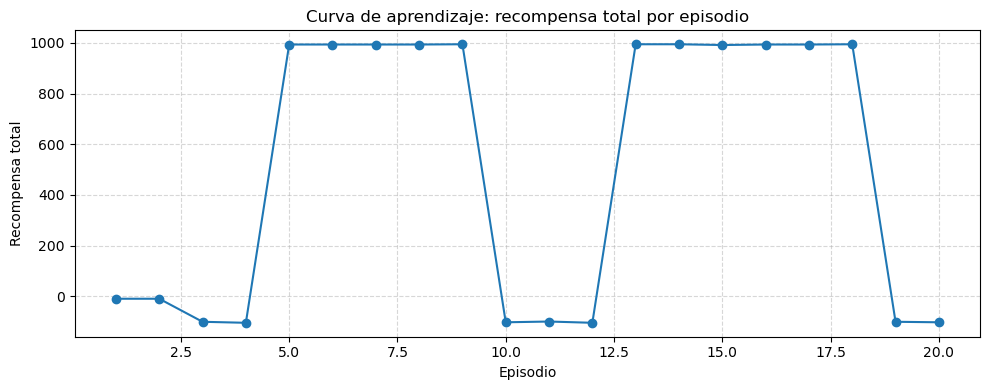

In [ ]:
# ESCRIBA AQUI SU RESPUESTA A LA PREGUNTA 1

plt.figure(figsize=(10, 4))

plt.plot(
    recompensas_por_episodio["episodio"],
    recompensas_por_episodio["recompensa"],
    marker="o",
    linestyle="-",
)
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Curva de aprendizaje: recompensa total por episodio")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### Pregunta 2: solo un trofeo?

El juego esta muy simple, obvio que puede lograrlo... Que pasa si agregamos otro trofeo 🏆, y la condicion para ganar es que debe recoger **ambos** trofeos 🏆🏆 para terminar el juego?

Completa la clase `State` para implementar este funcionamiento.

> Implementen lo necesario para que se necesiten 2 trofeos para terminar el juego. Rellenen el codigo en las secciones anteriores, y modifiquen lo necesario

### Pregunta 3: agreguemos mas cosas!!

Nuestro juego ya tiene zombies 🧟, trofeos 🏆 y a nuestro heroe 🙃. Ademas, agregamos esta condicion extra para necesitar mas de 1 trofeo para terminar el juego. Es momento de hacerlo mas entretenido.

Ahora deberan agregar los siguientes elementos al juego:

1.   Bloques 🚫: el heroe 🙃 no puede pasar por aqui, es lo mismo a chocar con una muralla.
2.   Puerta 🚪: un tipo de bloqueo, pero que puede ser desbloqueado consiguiendo la llave que abre la puerta. El heroe 🙃 no puede pasar por aqui hasta que consigua la llave 🔑.
3.   Llave 🔑: un objeto que esta en alguna parte del mapa. Una vez conseguimos este objeto podemos abrir una de las puertas del juego.

Ayudas e indicaciones:

*   Los bloques 🚫 son lo mismo que una muralla, solo se ven distintos y, claro, no estan en los extremos del mapa. No hay forma de destruirlos y no impactan al jugador, solo estan ahi para estorbar.
*   Puedes considerar que una vez abierta la puerta 🚪, esta desaparece. No te preocupes de esto ya que no es la idea de la actividad. Solo debes implementar la condicion que la puerta no puede atravesarse hasta conseguir la llave 🔑.
*   Para la llave 🔑 hay 2 opciones. Puedes considerar que solo se puede usar una vez y luego para abrir una segunda puerta hay que buscar una nueva, o que una sirve para todas. Esto no es lo importante, asi que puedes implementar lo que consideres mas entretenido :-)
*   Estos nuevos elementos se llaman `BLOCK` 🚫, `DOOR` 🚪 y `KEY` 🔑, y fueron definidos al principio de este documento. Debes modificar las funciones que interactuan con estos elementos. En la clase `State` puedes agregar si el heroe tiene ya la llave o no.

> Implementen los Bloques 🚫, Puertas 🚪 y Llaves 🔑 en el juego. Una puerta solo puede abrirse una vez conseguida una llave.





Hasta aqui llega el primer dia! Algunas cosas para que se vayan pensado:

*   Funciona con tantos elementos el juego tal y como lo definimos?
*   Esta aprendiendo nuestro heroe todas estas mecanicas complejas del juego? Como podriamos ayudar?

---
---
---

Desde aqui continuamos: dia 2!



### Pregunta 4: hora de enfrentarse a los zombies 🧟

Hasta ahora solo hemos evitado a los zombies 🧟, pero ya no mas! Es hora de hacerles frente, asi que agregaremos una espada 🗡️ al juego. Los zombies siguen siendo peligrosos al heroe 🙃 si esta desarmado, pero una vez el heroe 🙃 consigue la espada 🗡️ puede enfrentarlos. Cuando el heroe consigue la espada 🗡️, si toca a un zombie este desaparece del mapa y da una recompensa al heroe, algo asi como puntos extra.

Ayudas:

*   Primero debes agregar la espada 🗡️ al juego, y luego sumarla a las condiciones de estado de `State`. Es muy similar a la llave 🔑 y puerta 🚪, solo que ahora el zombie ya existia.

> Implementen la espada 🗡️ en el juego. Cuando el heroe 🙃 tiene la espada 🗡️, puede vencer facilmente a los zombies 🧟.

### Pregunta 5: no funciona...

Nuestro heroe no esta siendo capaz de aprender a jugar el nuevo juego despue de agregar tantas cosas. Hemos hecho el juego demasiado dificil?

> Indiquen que cosas hay que cambiar en las configuraciones del aprendizaje para que ahora si podamos ganar. Intenten con el mapa que dejamos mas abajo.

Respuesta a **pregunta 5**.

Escriba aqui su respuesta...

In [ ]:
grid = [
    [TROPHIE, EMPTY, EMPTY, EMPTY, ZOMBIE, TROPHIE, BLOCK, BLOCK],
    [ZOMBIE, ZOMBIE, BLOCK, EMPTY, BLOCK, BLOCK, BLOCK, BLOCK],
    [DOOR, EMPTY, EMPTY, EMPTY, BLOCK, BLOCK, BLOCK, BLOCK],
    [TROPHIE, BLOCK, EMPTY, EMPTY, BLOCK, BLOCK, BLOCK, BLOCK],
    [ZOMBIE, EMPTY, EMPTY, EMPTY, EMPTY, EMPTY, EMPTY, BLOCK],
    [EMPTY, EMPTY, BLOCK, EMPTY, BLOCK, BLOCK, EMPTY, BLOCK],
    [EMPTY, ZOMBIE, BLOCK, KEY, BLOCK, BLOCK, EMPTY, BLOCK],
    [EMPTY, EMPTY, EMPTY, BLOCK, BLOCK, BLOCK, SWORD, BLOCK]
]
print(Grid(grid))


### Pregunta 6: no funcionaba... por que?

> Por que hubo que cambiar esos parametros en la pregunta 5? Den un comentario respecto a lo que hacen esos parametros y por que cambiarlos arreglo todo nuestro problema

Ayudas:

*   Cuando juegas un juego, entiendes todo a la primera, o hay que intentarlo varias veces para acordarse?
*   Al jugar algo, o aprender una nueva habilidad, hay que practicarlo miles de veces 1 segundo, o unas 100 veces pero mas tiempo?



Respuesta a **pregunta 6**.

Escriba aqui su respuesta...

### Pregunta 7: Recompensa negativa al movernos

Durante todo este tiempo, en la funcion `act`, cada vez que nuestro heroe se movia a un lugar vacio, es decir, se movia respetando todas las reglas, le dabamos una recompensa de `-1`. Especificamente asi:
```python
...
elif grid_item == EMPTY:
    reward = -1
    is_done = False
...
```
Esto quiere decir que hemos estado castigando al heroe cada vez que se mueve... Por que? Podriamos borrar esa condicion y dar una recompensa positiva? Una recompensa de 0? Comenten sobre que opinan de esto y para que creen que sirve.

> Por que la recompensa de moverse es negativa? Que pasaria si la cambiamos a una recompensa positiva, o 0?

Respuesta a **pregunta 7**.

Escriba aqui su respuesta...

### Pregunta Extra: murallas fijas

Siempre hemos considerado que las murallas del mapa son fijas y no podemos cruzarlas, pero, que ocurre si pudieramos atravesarlas y aparecer al otro lado? Implemente este cambio y cuente sus resultados.

> Implemente el poder atravesar uno de los limites del mapa y aparecer en el otro lado.

Aclaracion: esta es una pregunta opcional y no es requerido responderla para la nota (pero puede haber algo extra ;-).


Respuesta a **pregunta extra**.

Escriba aqui su respuesta...